<a href="https://colab.research.google.com/github/Nao-Ishi/play_py/blob/master/Q_learning_multigoal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 単一スタート＋複数ゴールSarsa,Q学習
イメージ：現在地から一番近いゴールを目指す。そこから更に一番近いゴールを目指す。

# エージェントの定義
エージェント
- 仮想的なロボット（ロボットの知能部分
- 自分の起こせる行動(self.actions
- 自分のいる座標(self.pos


In [0]:
class Agent:
    def __init__(self):
        self.actions = ["up","down","left","right"]
        self.pos = (0,0)
        
agent = Agent()

# 環境の定義
初期化(init
- 全域をgoalとして初期化
- 測定点とその周囲をペナルティエリアとして更新？再考の必要あり


In [0]:
size = 20 #タイルワールドの全体サイズ　可変

class State:
    def __init__(self,actions):
        self.Q = {}
        for a in actions:
            self.Q[a] = 10.0
        self.best_action = "up"
        self.goal = False
        self.pa = False
        
    def set_goal(self,actions):
        for a in actions:
            self.Q[a] =0.0
        self.goal = True
        self.pa = False
        
    def set_pa(self,actions):
        for a in actions:
            self.Q[a] += 5.0
        self.goal = False
        self.pa = True
        
        
#設定したサイズ文のタイルワールドを定義  
states = [[State(agent.actions) for i in range(size)] for j in range(size)]
for i in range(size):
    for j in range(size):
        states[i][j].set_goal(agent.actions)
    
#障害の定義（今回は侵入しても良い→壁とは違う→無理やり突っ込むことも　変更可　複数宣言可
""" 
for i in range(3):
    for j in range(3):
        states[i+1][j+2].set_pa(agent.actions)
  
for i in range(5):
    for j in range(7):
        states[i+3][j+7].set_pa(agent.actions)
"""

' \nfor i in range(3):\n    for j in range(3):\n        states[i+1][j+2].set_pa(agent.actions)\n  \nfor i in range(5):\n    for j in range(7):\n        states[i+3][j+7].set_pa(agent.actions)\n'

# 描画
前セルで作成したタイルワールドをプロット。

表示内容は下段：最適な行動、上段：その報酬

本プログラムではゴールまでの歩数＝報酬としているので報酬が低い方へ進んでいく


In [0]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

fig_num = 0

def draw(mark_pos):
    global fig_num
    fig, ax = plt.subplots()
    values = [[states[i][j].Q[states[i][j].best_action] for j in range(size)] for i in range(size)]
    mp = ax.pcolor(values, cmap=plt.cm.YlOrRd,vmin=0,vmax=30)
    ax.set_aspect(1)
    ax.set_xticks(range(size), minor=False)
    ax.set_yticks(range(size), minor=False)
  
    
    for x in range(len(values)):
        for y in range(len(values[0])):
            s = states[y][x]
            #plt.text(x+0.5,y+0.5,int(1000*s.Q[s.best_action])/1000,ha = 'center', va = 'center', size=10)
            #if states[y][x].goal:
                #plt.text(x+0.75,y+0.75,"G",ha = 'center', va = 'center', size=20)
                
    #plt.text(agent.pos[0]+0.5,agent.pos[1]+0.25,"agent",ha = 'center', va = 'center', size=20)
    
    #if mark_pos == "all":   # 指定した位置にactionの文字列を書くという処理
        #for x in range(size):
            #for y in range(size):
                #if states[y][x].goal: continue
                #plt.text(x+0.5,y+0.25,states[y][x].best_action,ha = 'center', va = 'center', size=10)
    #elif mark_pos != None: 
        #s = states[mark_pos[0]][mark_pos[1]]
        #plt.text(mark_pos[0]+0.5,mark_pos[1]+0.25,s.best_action,ha = 'center', va = 'center', size=10)  
    
#    fig_num_s = ""
#    if fig_num< 10:
#        fig_num_s = "00" + str(fig_num)
#    elif fig_num<100:
#        fig_num_s = "0" + str(fig_num)
#    else :
#        fig_num_s = str(fig_num)
    plt.savefig(str(fig_num) + ".png",bbox_inches='tight')
    fig_num += 1
    #plt.show()
    fig.clear()

    
draw("all")

<Figure size 432x288 with 0 Axes>

# 状態遷移の実装
現在座標と行動を引数として、行動後の座標を返します。

頭打ち処理でエリア外への脱走防止。

In [0]:
import random

def state_transition(s_pos,a):
    ###確率10%で元のまま ###
    if random.uniform(0,1) < 0.1:
        return s_pos
    
    x,y = s_pos
    if   a == "up": x += 1
    elif a == "down": x -= 1
    elif a == "right": y += 1
    elif a == "left": y -= 1
        
    if x < 0:       x = 0
    elif x >= size: x = size-1
    if y < 0:       y = 0
    elif y >= size: y = size-1
        
    return (x,y)

# 方策(ε-greedy)
たまに変な方向へ行く

Sarsa用

In [0]:
def e_greedy(s):
    if random.uniform(0,1) < 0.1: #10%でランダムに
        return random.choice(agent.actions)
    else:
        best_a = None
        best_q = 1000000000
        for a in s.Q:
            if best_q > s.Q[a]:
                best_q = s.Q[a]
                best_a = a
        s.best_action = best_a
        return best_a

# 方策(greedy)
常に最適なものを選ぶ

Q学習用

In [0]:
def max_a(s):
    best_a = None
    best_q = 1000000000
    for a in s.Q:
        if best_q > s.Q[a]:
            best_q = s.Q[a]
            best_a = a
    s.best_action = best_a
    return best_a

# 学習
現状は単一ゴール、ランダムスタートで学習

一般的な迷路探索問題+障害ペナルティ（水たまり的な

In [0]:
alpha = 0.2 #学習係数　今回の事象をどの程度反映させるか、高すぎると偶発的な事象に引っ張られるので注意
gamma = 1.0 #割引率　　一般的に0.99-0.9辺りが使われる

def sarsa(s_pos,a):
    s = states[s_pos[0]][s_pos[1]]
    s_next_pos = state_transition(s_pos,a)
    s_next = states[s_next_pos[0]][s_next_pos[1]]
    #a_next = max_a(s_next)#次の状態で一番良いaで学習 Q-leaning
    a_next = e_greedy(s_next)#次の状態で選んだaで学習 Sarsa
    
    #qの更新式
    q = (1.0-alpha)*s.Q[a] + alpha * (1.0 + gamma * s_next.Q[a_next] + states[s_next_pos[0]][s_next_pos[1]].pa * 10)
    #if states[s_pos[0]][s_pos[1]].pa:
    #    q = q + 20
    #print("s:" + str(s_pos)+ "　a:" + a + " s':" + str(s_next_pos) + " a':" + a_next)
    #print("----")
    return s_next_pos, a_next, q

def one_trial(s_pos):
    agent.pos = s_pos
    #agent.pos = (0,0)
    a = e_greedy(states[agent.pos[0]][agent.pos[1]])
    if states[agent.pos[0]][agent.pos[1]].goal:
        return
          
    for i in range(100):
        #draw(None)
        s_next, a_next, q = sarsa(agent.pos,a)
        states[agent.pos[0]][agent.pos[1]].Q[a] = q
        agent.pos = s_next
        a = a_next            
        if states[agent.pos[0]][agent.pos[1]].goal:
            break
"""            
n = 0            
for i in range(10000):
    one_trial(agent.pos)
    
    if i==10**n-1:
        print(i+1)
        n +=1
        draw(None)
      

#plt.show()
"""

'            \nn = 0            \nfor i in range(10000):\n    one_trial(agent.pos)\n    \n    if i==10**n-1:\n        print(i+1)\n        n +=1\n        draw(None)\n      \n\n#plt.show()\n'

# 測定とマップの再定義
測定地点（現在のスタート地点）と周囲8マスをペナルティエリアとする

マップに深さ（信頼度？）の概念入れた方が良い気がする

ゴール消滅問題　終了処理をどうするか…とりあえずゴールが無くなったらで

In [0]:
def do_measurememt(s_pos):
    for i in range(3):
        for j in range(3):
            if (s_pos[0]+i-1)>=0 and  (s_pos[0]+i-1)<size and (s_pos[1]+j-1)>=0 and (s_pos[1]+j-1)<size:
                states[s_pos[0]+i-1][s_pos[1]+j-1].set_pa(agent.actions)

#agent.pos=(0,0)
def demo_():
    agent.pos = (random.randrange(size),random.randrange(size))
    while True:
        goal_detect = False
        for i in range(size):
            for j in range(size):
                goal_detect|=states[i][j].goal
        if goal_detect==False:
            break

        
        for i in range(10000):
            one_trial(agent.pos)
        do_measurememt(agent.pos)
        
        
        draw("all")

demo_()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

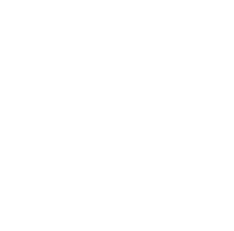

In [0]:
from PIL import Image
 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
 
picList  =[]
for i in range(fig_num) :
    picList.append(str(i)+".png")
     
#figオブジェクトの作成
fig = plt.figure()

#figオブジェクトから目盛り線などを消す
plt.axis('off')
     
ims = []
     
#画像ファイルを空のリストの中に1枚ずつ読み込み
for i in range(len(picList)):
         
    #読み込んで付け加えていく
    tmp = Image.open(picList[i])
    ims.append([plt.imshow(tmp)])     
     
ani = animation.ArtistAnimation(fig, ims, interval=300, repeat_delay=3000)
 
#アニメーション保存。
ani.save('0_measurement.gif', writer='pillow')